In [1]:
"""
Ensure bez2018model has been installed: `python setup.py build_ext --inplace`
"""

import sys
import os
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import bez2018model
import util_demo


In [2]:
"""
Generate example stimulus
"""

fs = 32000
dur = 0.150 # <-- duration of stimulus (150 ms tone)
snr = 5.0
dbspl = 60.0

signal = util_demo.complex_tone(
    f0=200,
    fs=fs,
    dur=dur,
    harmonic_numbers=np.arange(1, 31),
    frequencies=None,
    amplitudes=None,
    phase_mode='sine',
    offset_start=True,
    strict_nyquist=True)

noise = np.random.randn(signal.shape[0])
y = util_demo.combine_signal_and_noise(signal, noise, snr=snr)
y = util_demo.set_dBSPL(y, dbspl)

ipd.display(ipd.Audio(y, rate=fs))


In [3]:
"""
Run auditory nerve model
"""

kwargs_nervegram = {
    'nervegram_dur': 0.05, # <-- duration of final nervegram in seconds (<= stimulus duration)
    'nervegram_fs': 20e3, # <-- sampling rate of nervegram in Hz
    'buffer_start_dur': 0.070, # <-- trim first 70ms of the full-length nervegram
    'buffer_end_dur': 0.010, # <-- trim last 10ms of the full-lenght nervegram
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0, # <-- scale cochlear filter bandwidths
    'cf_list': None,
    'num_cf': 100, # <-- specify 100 freqency channels ERB-spaced between 125 and 14000 Hz
    'min_cf': 125,
    'max_cf': 14e3,
    'max_spikes_per_train': -1,
    'num_spike_trains': 20, # <-- number of spike trains to sample per frequency channel
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000, # <-- adjust upper frequency limit of auditory nerve phase-locking
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': False, # <-- "nervegram_vihcs" contains instantaneous IHC voltages
    'return_meanrates': True, # <-- "nervegram_meanrates" contains instantaneous firing rates
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': True, # <-- "nervegram_spike_tensor_dense" contains individual spikes
    'nervegram_spike_tensor_fs': 10e3, # <-- sampling rate of dense spike tensor in Hz
}

# NOTE: run times will be slow if spikes are requested, especially for large `num_spike_trains`
# (set `return_spike_*` flags to False if instantaneous firing rate estimates are sufficient)

t0 = time.time()
nervegram_output_dict = bez2018model.nervegram(y, fs, **kwargs_nervegram)
t1 = time.time()
print("Auditory nerve model run time: {:.2f} seconds".format(t1-t0))
print("Auditory nerve model outputs: (key, shape, dtype / value)")
for k in sorted(nervegram_output_dict.keys()):
    if len(np.array(nervegram_output_dict[k]).shape) == 0:
        print('|__', k, np.array(nervegram_output_dict[k]).shape, nervegram_output_dict[k])
    else:
        print('|__', k, np.array(nervegram_output_dict[k]).shape, np.array(nervegram_output_dict[k]).dtype)


Auditory nerve model run time: 6.75 seconds
Auditory nerve model outputs: (key, shape, dtype / value)
|__ IhcLowPass_cutoff () 3000
|__ IhcLowPass_order () 7
|__ bandwidth_scale_factor (100,) float32
|__ buffer_end_dur () 0.01
|__ buffer_start_dur () 0.07
|__ cf_list (100,) float32
|__ cihc (100,) float64
|__ cohc (100,) float64
|__ implnt () 0
|__ max_spikes_per_train () -1
|__ nervegram_dur () 0.05
|__ nervegram_fs () 20000.0
|__ nervegram_meanrates (100, 1000) float32
|__ nervegram_spike_tensor_dense (20, 100, 500) bool
|__ nervegram_spike_tensor_fs () 10000.0
|__ noiseType () 0
|__ num_spike_trains () 20
|__ pin (5000,) float32
|__ pin_dBSPL () 59.961930406396064
|__ pin_dBSPL_flag () 0
|__ pin_fs () 100000.0
|__ signal (1600,) float32
|__ signal_fs () 32000
|__ species () 2
|__ spont () 70.0
|__ synapseMode () 0
|__ tabs () 0.0006
|__ trel () 0.0006


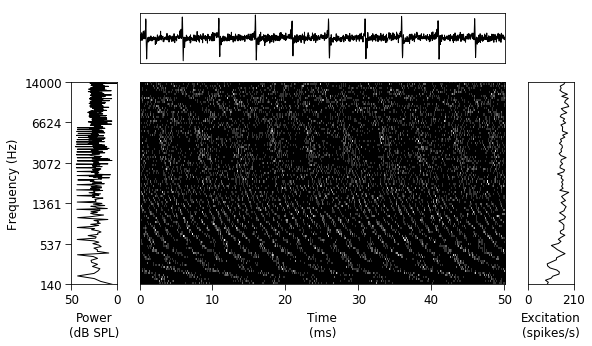

In [7]:
"""
Visualize stimulus and simulated auditory nerve representations
"""

# key_to_plot = 'nervegram_meanrates'
key_to_plot = 'nervegram_spike_tensor_dense'

figsize=(9, 5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = nervegram_output_dict['signal']
sr_waveform = nervegram_output_dict['signal_fs']
cfs = nervegram_output_dict['cf_list']

if key_to_plot == 'nervegram_spike_tensor_dense':
    # Plot spike trains summed within frequency channels
    n_anf = nervegram_output_dict['nervegram_spike_tensor_dense'].shape[0]
    nervegram = nervegram_output_dict['nervegram_spike_tensor_dense'].sum(axis=0)
    sr_nervegram = nervegram_output_dict['nervegram_spike_tensor_fs']
else:
    # Plot instantaneous firing rate estimates
    n_anf = None
    nervegram = nervegram_output_dict[key_to_plot]
    sr_nervegram = nervegram_output_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_demo.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=waveform,
    nervegram=nervegram,
    sr_waveform=sr_waveform,
    sr_nervegram=sr_nervegram,
    cfs=cfs,
    n_anf=n_anf)
plt.show()
